# Movie Rating Prediction / Recommender System
- **MovieLens Dataset**
- **Goal:** Predict how a user would rate a movie and recommend new movies based on their preferences.

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from math import sqrt

# For displaying dataframe better
pd.set_option('display.max_columns', None)

In [2]:
# Download and load dataset
ratings = pd.read_csv('https://files.grouplens.org/datasets/movielens/ml-100k/u.data', 
                      sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

movies = pd.read_csv('https://files.grouplens.org/datasets/movielens/ml-100k/u.item',
                     sep='|', encoding='latin-1',
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 
                            'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                            'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 
                            'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
                            'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)

print(ratings.head())

Ratings shape: (100000, 4)
Movies shape: (1682, 24)
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100000 non-null  int64 
 1   movie_id   100000 non-null  int64 
 2   rating     100000 non-null  int64 
 3   timestamp  100000 non-null  int64 
 4   title      100000 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB
None
            user_id       movie_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.0

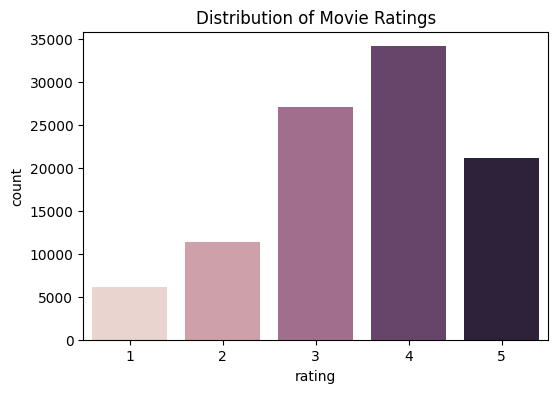

In [9]:
# ============================================
# DATA EXPLORATION
# ============================================

# Merge datasets
df = pd.merge(ratings, movies[['movie_id', 'title']], on='movie_id')

# Basic overview
print(df.info())
print(df.describe())

# Check missing values
print(df.isnull().sum())

# Distribution of ratings
plt.figure(figsize=(6,4))
sns.countplot(x='rating', hue='rating', data=df, legend=False)
plt.title("Distribution of Movie Ratings")
plt.show()

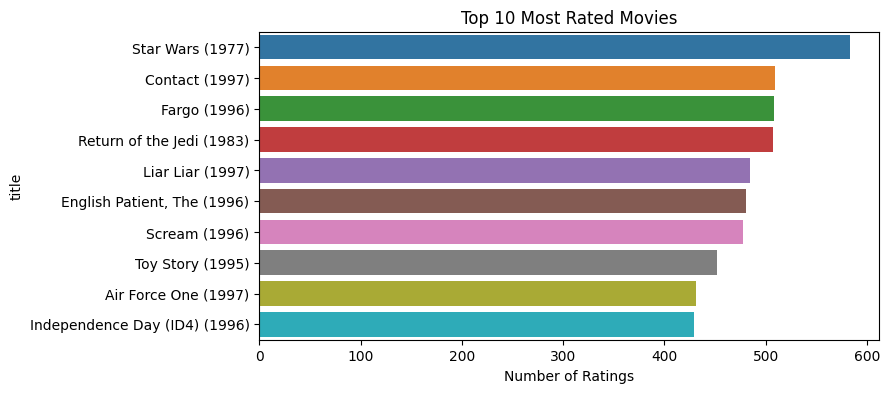

In [8]:
# Top 10 Most Rated Movies
top_movies = df['title'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_movies.values, y=top_movies.index, hue=top_movies.index, legend=False)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.show()

In [ ]:
# ============================================
# BUILD RECOMMENDATION MODEL (SVD) Single Value Decomposition
# ============================================

# Create user-item matrix
user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')

# Fill NaN with 0 (no rating)
user_item_matrix_filled = user_item_matrix.fillna(0)

# Convert to sparse matrix for efficiency
sparse_matrix = csr_matrix(user_item_matrix_filled.values)

# Apply SVD (Matrix Factorization)
n_components = 50  # Number of latent factors
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_features = svd.fit_transform(sparse_matrix)
item_features = svd.components_

# Reconstruct the matrix (predicted ratings)
predicted_ratings = np.dot(user_features, item_features)

# Create DataFrame for predictions
predicted_df = pd.DataFrame(
    predicted_ratings,
    index=user_item_matrix.index,
    columns=user_item_matrix.columns
)

In [11]:
# ============================================
# MODEL EVALUATION
# ============================================

# Calculate RMSE on known ratings
actual = user_item_matrix_filled.values
predicted = predicted_ratings
mask = user_item_matrix.values > 0  # Only evaluate known ratings

rmse = sqrt(mean_squared_error(actual[mask], predicted[mask]))
print(f"\nModel RMSE: {rmse:.4f}")


Model RMSE: 1.8589


In [12]:
# ============================================
# MAKE PREDICTIONS
# ============================================

def predict_rating(user_id, movie_id):
    """Predict rating for a user-movie pair"""
    if user_id in predicted_df.index and movie_id in predicted_df.columns:
        pred = predicted_df.loc[user_id, movie_id]
        # Clip to valid rating range
        return np.clip(pred, 1, 5)
    return None

# Test prediction
user_id = 100
movie_id = 50
pred = predict_rating(user_id, movie_id)
print(f"\nPredicted rating for User {user_id}, Movie {movie_id}: {pred:.2f}")



Predicted rating for User 100, Movie 50: 1.00


In [13]:
# ============================================
# RECOMMEND MOVIES FOR A USER
# ============================================

def recommend_movies(user_id, n_recommendations=10):
    """Get top N movie recommendations for a user"""
    if user_id not in predicted_df.index:
        return []
    
    # Get user's predictions
    user_predictions = predicted_df.loc[user_id]
    
    # Get movies user hasn't rated
    user_rated = user_item_matrix.loc[user_id]
    unrated_movies = user_rated[user_rated.isna()].index
    
    # Get predictions for unrated movies
    recommendations = user_predictions[unrated_movies].sort_values(ascending=False)
    
    # Get top N
    top_recommendations = recommendations.head(n_recommendations)
    
    return top_recommendations

In [14]:
# Get recommendations
user_id = 100
recommendations = recommend_movies(user_id, n_recommendations=10)

print(f"\nTop 10 Recommended Movies for User {user_id}:")
for movie_id, predicted_rating in recommendations.items():
    movie_title = movies[movies['movie_id'] == movie_id]['title'].values[0]
    print(f"{movie_title}: Predicted Rating {predicted_rating:.2f}")



Top 10 Recommended Movies for User 100:
Devil's Advocate, The (1997): Predicted Rating 2.57
Edge, The (1997): Predicted Rating 1.93
Saint, The (1997): Predicted Rating 1.80
Kiss the Girls (1997): Predicted Rating 1.76
Alien: Resurrection (1997): Predicted Rating 1.75
In & Out (1997): Predicted Rating 1.74
Cop Land (1997): Predicted Rating 1.65
Midnight in the Garden of Good and Evil (1997): Predicted Rating 1.48
Devil's Own, The (1997): Predicted Rating 1.35
Murder at 1600 (1997): Predicted Rating 1.31


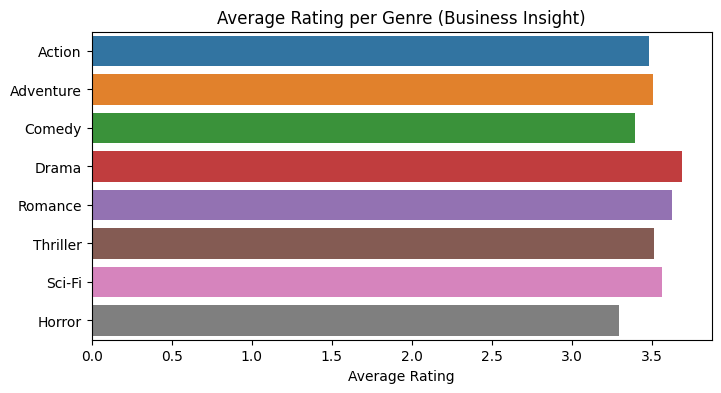

In [15]:
# ============================================
# BUSINESS INSIGHTS
# ============================================

# Average rating per genre
genre_cols = ['Action','Adventure','Comedy','Drama','Romance','Thriller','Sci-Fi','Horror']

# Merge to get genre info
df_full = pd.merge(ratings, movies[['movie_id'] + genre_cols], on='movie_id')

genre_ratings = {}
for genre in genre_cols:
    genre_mask = df_full[genre] == 1
    if genre_mask.any():
        genre_ratings[genre] = df_full[genre_mask]['rating'].mean()

plt.figure(figsize=(8,4))
sns.barplot(x=list(genre_ratings.values()), y=list(genre_ratings.keys()), 
            hue=list(genre_ratings.keys()), legend=False)
plt.title("Average Rating per Genre (Business Insight)")
plt.xlabel("Average Rating")
plt.show()

In [16]:
# ============================================
# ADDITIONAL ANALYSIS
# ============================================

# User activity
user_activity = ratings.groupby('user_id').size()
print(f"\nAverage ratings per user: {user_activity.mean():.2f}")
print(f"Most active user rated {user_activity.max()} movies")

# Movie popularity
movie_popularity = ratings.groupby('movie_id').size()
print(f"\nAverage ratings per movie: {movie_popularity.mean():.2f}")
print(f"Most popular movie has {movie_popularity.max()} ratings")


Average ratings per user: 106.04
Most active user rated 737 movies

Average ratings per movie: 59.45
Most popular movie has 583 ratings
